In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from pycwt import cwt,xwt,wct,wct_significance,wavelet,Morlet
import matplotlib.dates as mdates
import pandas as pd
import os

from scipy.signal import detrend
path = "/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/7adcp_biomass/graft_filled/"
files = sorted([f for f in os.listdir(path) if f.endswith(".nc")])

In [2]:
patho = "/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/8process/wavelet/40m_wavelet/"

In [3]:
# to study the semi-annual and annual cycle
#ds40d = ds40.resample(TIME1='24h').mean()
s0 = 24
dt = 1
dj = 0.125
#J = int(np.log2(24*365*3 / s0) / dj)
mother = wavelet.Morlet(6.)

In [4]:
# to study the intra-seasonal cycle
#ds40d = ds40.resample(TIME1='24h').mean()
s0 = 2
dt = 0.25
dj = 0.03125
#J = int(np.log2(24*365*3 / s0) / dj)
mother = wavelet.Morlet(6.)

# find correlation between ss and 40 m biomass

In [6]:
path = "/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/7adcp_biomass/graft_filled/"
files = sorted([f for f in os.listdir(path) if f.endswith(".nc")])

pathss = "/media/scilab/disk_ranjan/works/westcoast_adcp1/backscatternew/7adcp_biomass/ss/"
filess = sorted([f for f in os.listdir(pathss) if f.endswith(".nc")])
ss = [xr.open_dataset(pathss+filess[i]) for i in range(7)]

bm = [xr.open_dataset(path+files[i]) for i in range(7)]

for i in range(7):
    ds40 = bm[i].sel(DEPTH=40,method="nearest")
    corr = xr.corr(ss[i].SS[:,0,0],ds40.BIOMASS[:,0,0])
    print(np.round(corr.values,4))

0.7749
0.7903
0.6395
0.5791
0.5211
0.6775
0.7262


# OKHA 

In [4]:
ds = xr.open_dataset(path+files[0])
ds40 = ds.sel(DEPTH=40,method="nearest")
bm40d = np.array(ds40.BIOMASS.values)

In [5]:
bm40d_1 = detrend(bm40d[0:10099,0,0])
wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm40d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm40d_1)
alpha, _, _ = wavelet.ar1(bm40d_1)  # Lag-1 autocorrelation for red noise
std = bm40d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951

bm40d_2 = detrend(bm40d[18963:45401,0,0])
wave2, scales2, freqs2, coi2, fft2, fftfreqs2 = cwt(bm40d_2,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power2 = (np.abs(wave2)) ** 2  # Wavelet power spectrum
period2 = 1 / freqs2  # Convert frequencies to periods

N = len(bm40d_2)
alpha, _, _ = wavelet.ar1(bm40d_2)  # Lag-1 autocorrelation for red noise
std = bm40d_2.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_2, dt, scales2, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig952 = np.ones([1, N]) * signif[:, None]
sig952 = power2 / sig952

Text(0, 0.5, 'period (days)')

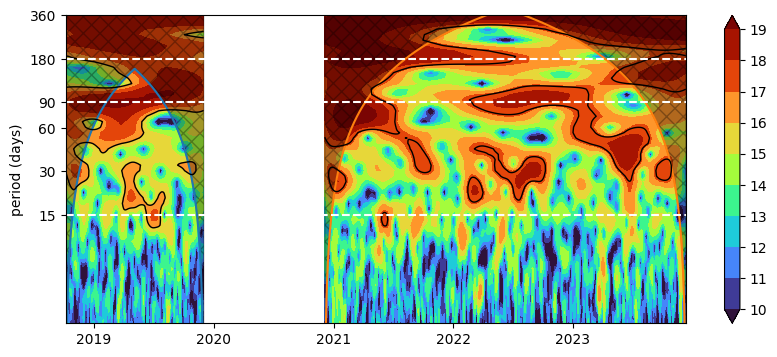

In [6]:
plt.figure(figsize=(10,4))

x = plt.contourf(ds40.TIME1[0:10099], np.log2(period1), np.log2(power1), extend='both',cmap="turbo",levels=np.arange(10,20,1))
plt.plot(ds40.TIME1[0:10099], np.log2(coi1))
plt.fill_between(ds40.TIME1[0:10099],np.log2(coi1),16,color='k',alpha=0.3,hatch='xx')
extent = [ds40.TIME1[0:10099].min(), ds40.TIME1[0:10099].max(), 0, max(period1)]
plt.contour(ds40.TIME1[0:10099], np.log2(period1), sig951,levels=[-99,1], colors='k', linewidths=1,extent=extent)

plt.contourf(ds40.TIME1[18963:45401], np.log2(period2), np.log2(power2), extend='both',cmap="turbo",levels=np.arange(10,20,1))
plt.plot(ds40.TIME1[18963:45401], np.log2(coi2))
plt.fill_between(ds40.TIME1[18963:45401],np.log2(coi2),16,color='k',alpha=0.3,hatch='xx')
extent = [ds40.TIME1[18963:45401].min(), ds40.TIME1[18963:45401].max(), 0, max(period2)]
plt.contour(ds40.TIME1[18963:45401], np.log2(period2), sig952,levels=[-99,1], colors='k', linewidths=1,extent=extent)


plt.axhline(np.log2(24),color='w',linestyle='--')
plt.axhline(np.log2(24*15),color='w',linestyle='--')
plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')


plt.colorbar(x)

plt.ylim(6,13)
customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [7]:
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1[0:10099].values})
wavpow2=xr.DataArray(
    data=power2,
    dims=["period","time"],
    coords={"period":period2,'time':ds40.TIME1[18963:45401].values})

ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds40.TIME1[0:10099].values})
ci2=xr.DataArray(
    data=coi2,
    dims=["time"],
    coords={'time':ds40.TIME1[18963:45401].values}
)

sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1[0:10099].values})
sig2=xr.DataArray(
    data=sig952,
    dims=["period","time"],
    coords={"period":period2,'time':ds40.TIME1[18963:45401].values})
ds = xr.Dataset({
    'wavpow1': wavpow1,
    'wavpow2': wavpow2,
    'sig1': sig1,
    'sig2': sig2,
    'coi1': ci1,
    'coi2': ci2,
})
ds.to_netcdf(patho+str(files[0]))

# for daily resampled data

In [ ]:
ds = xr.open_dataset(path+files[0])
ds40 = ds.sel(DEPTH=40,method="nearest").resample(TIME1='24h').mean()
bm40d = np.array(ds40.BIOMASS[:,0,0].values)

s0 = 2
dj = 0.01
#J = int(np.log2(24*365*3 / s0) / dj)
mother = wavelet.Morlet(6.)
bm40d_1 = detrend(bm40d[0:422])
wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm40d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

plt.contourf(ds40.TIME1[0:422], np.log2(period1), np.log2(power1), extend='both',cmap="turbo",levels=np.arange(10,15,0.1))
#plt.contourf(wave1,cmap="turbo",levels=(np.arange(20,60,10)),extend="both")
plt.plot(ds40.TIME1[0:422], np.log2(coi1))
plt.fill_between(ds40.TIME1[0:422],np.log2(coi1),10,color='k',alpha=0.3,hatch='xx')
plt.colorbar()

# mumbai

In [7]:
ds = xr.open_dataset(path+files[1])
ds40 = ds.sel(DEPTH=40,method="nearest")
bm40d = np.array(ds40.BIOMASS[:,0,0].values)


In [8]:
bm40d_1 = detrend(bm40d)

wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm40d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

Text(0, 0.5, 'period (days)')

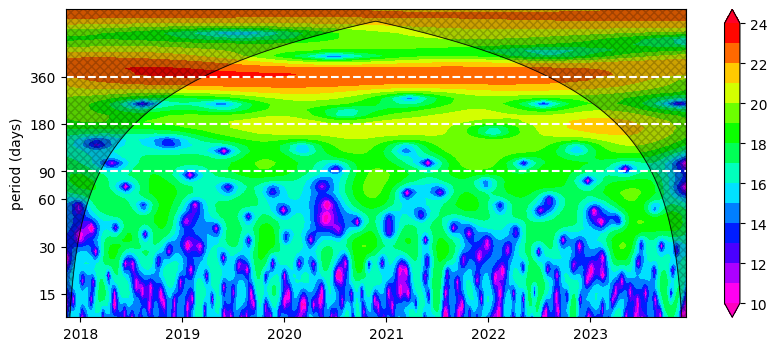

In [9]:
plt.figure(figsize=(10,4))

plt.contourf(ds40.TIME1, np.log2(period1), np.log2(power1), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,1))
plt.plot(ds40.TIME1, np.log2(coi1),color='k',linewidth=0.5)
plt.fill_between(ds40.TIME1,np.log2(coi1),16,color='k',alpha=0.2,hatch='xxxx')

plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')

plt.colorbar()
plt.ylim(8,14.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [11]:
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm40d_1)
alpha, _, _ = wavelet.ar1(bm40d_1)  # Lag-1 autocorrelation for red noise
std = bm40d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1.values})
ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds40.TIME1.values})
sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1.values})

ds = xr.Dataset({
    'wavpow1': wavpow1,
    'sig1': sig1,
    'coi1': ci1,
})

In [12]:
ds.to_netcdf(patho+str(files[1]))

# Jaigarh

In [3]:
ds = xr.open_dataset(path+files[2])
ds40 = ds.sel(DEPTH=40,method="nearest")
bm40d = np.array(ds40.BIOMASS[:,0,0].values)


In [4]:
bm40d_1 = detrend(bm40d[0:17569])
bm40d_2 = detrend(bm40d[27122:38136])
bm40d_3 = detrend(bm40d[45460:54408])


In [8]:
bm40d_1 = detrend(bm40d[0:17569])
wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm40d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm40d_1)
alpha, _, _ = wavelet.ar1(bm40d_1)  # Lag-1 autocorrelation for red noise
std = bm40d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951


bm40d_2 = detrend(bm40d[27122:38137])
wave2, scales2, freqs2, coi2, fft2, fftfreqs2 = cwt(bm40d_2,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power2 = (np.abs(wave2)) ** 2  # Wavelet power spectrum
period2 = 1 / freqs2  # Convert frequencies to periods

N = len(bm40d_2)
alpha, _, _ = wavelet.ar1(bm40d_2)  # Lag-1 autocorrelation for red noise
std = bm40d_2.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_2, dt, scales2, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig952 = np.ones([1, N]) * signif[:, None]
sig952 = power2 / sig952

bm40d_3 = detrend(bm40d[45460:])
wave3, scales3, freqs3, coi3, fft3, fftfreqs3 = cwt(bm40d_3,dt=1,dj=dj,s0=12, J=-1, wavelet=mother)
power3 = (np.abs(wave3)) ** 3  # Wavelet power spectrum
period3 = 1 / freqs3  # Convert frequencies to periods
N = len(bm40d_3)
alpha, _, _ = wavelet.ar1(bm40d_3)  # Lag-1 autocorrelation for red noise
std = bm40d_3.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_3, dt, scales3, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig953 = np.ones([1, N]) * signif[:, None]
sig953 = power3 / sig953

Text(0, 0.5, 'period (days)')

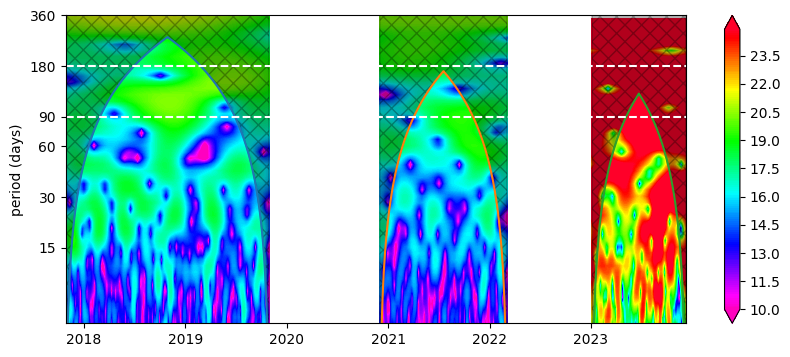

In [9]:
plt.figure(figsize=(10,4))
plt.contourf(ds40.TIME1[0:17569], np.log2(period1), np.log2(power1), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,0.1))
plt.plot(ds40.TIME1[0:17569], np.log2(coi1))
plt.fill_between(ds40.TIME1[0:17569],np.log2(coi1),16,color='k',alpha=0.3,hatch='xx')

plt.contourf(ds40.TIME1[27122:38137], np.log2(period2), np.log2(power2), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,0.1))
plt.plot(ds40.TIME1[27122:38137], np.log2(coi2))
plt.fill_between(ds40.TIME1[27122:38137],np.log2(coi2),16,color='k',alpha=0.3,hatch='xx')

plt.contourf(ds40.TIME1[45460:], np.log2(period3), np.log2(power3), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,0.1))
plt.plot(ds40.TIME1[45460:], np.log2(coi3))
plt.fill_between(ds40.TIME1[45460:],np.log2(coi3),16,color='k',alpha=0.3,hatch='xx')


plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')


plt.colorbar()
plt.ylim(7,12.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [86]:
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1[0:17569].values})
wavpow2=xr.DataArray(
    data=power2,
    dims=["period","time"],
    coords={"period":period2,'time':ds40.TIME1[27122:38137].values})
wavpow3=xr.DataArray(
    data=power3,
    dims=["period","time"],
    coords={"period":period3,'time':ds40.TIME1[45460:54408].values})

ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds40.TIME1[0:17569].values})
ci2=xr.DataArray(
    data=coi2,
    dims=["time"],
    coords={'time':ds40.TIME1[27122:38137].values})
ci3=xr.DataArray(
    data=coi3,
    dims=["time"],
    coords={'time':ds40.TIME1[45460:54408].values}
)
sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1[0:17569].values})
sig2=xr.DataArray(
    data=sig952,
    dims=["period","time"],
    coords={"period":period2,'time':ds40.TIME1[27122:38137].values})
sig3=xr.DataArray(
    data=sig953,
    dims=["period","time"],
    coords={"period":period3,'time':ds40.TIME1[45460:54408].values})


ds = xr.Dataset({
    'wavpow1': wavpow1,
    'wavpow2': wavpow2,
    'wavpow3': wavpow3,
    'sig1': sig1,
    'sig2': sig2,
    'sig3': sig3,
    'coi1': ci1,
    'coi2': ci2,
    'coi3': ci3,
})

In [87]:
ds.to_netcdf(patho+str(files[2]))

# Goa

In [10]:
ds = xr.open_dataset(path+files[3])
ds40 = ds.sel(DEPTH=40,method="nearest")
bm40d = np.array(ds40.BIOMASS[:,0,0].values)

bm40d_1 = detrend(bm40d)

wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm40d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

Text(0, 0.5, 'period (days)')

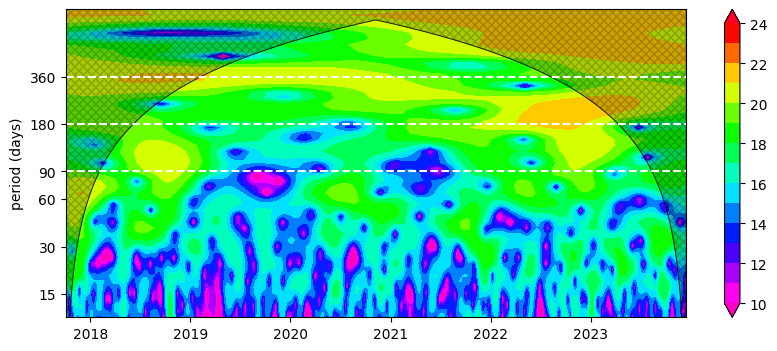

In [11]:
plt.figure(figsize=(10,4))

plt.contourf(ds40.TIME1, np.log2(period1), np.log2(power1), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,1))
plt.plot(ds40.TIME1, np.log2(coi1),color='k',linewidth=0.5)
plt.fill_between(ds40.TIME1,np.log2(coi1),16,color='k',alpha=0.2,hatch='xxxx')

plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')

plt.colorbar()
plt.ylim(8,14.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [12]:
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm40d_1)
alpha, _, _ = wavelet.ar1(bm40d_1)  # Lag-1 autocorrelation for red noise
std = bm40d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1.values})
ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds40.TIME1.values})
sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1.values})
ds = xr.Dataset({
    'wavpow1': wavpow1,
    'sig1': sig1,
    'coi1': ci1,
})


In [16]:
ds.to_netcdf(patho+str(files[3]))

# Udupi  

In [92]:
ds = xr.open_dataset(path+files[4])
ds40 = ds.sel(DEPTH=40,method="nearest")
bm40d = np.array(ds40.BIOMASS[:,0,0].values)


In [93]:
bm40d_1 = detrend(bm40d[0:27907])
wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm40d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

N = len(bm40d_1)
alpha, _, _ = wavelet.ar1(bm40d_1)  # Lag-1 autocorrelation for red noise
std = bm40d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951


bm40d_2 = detrend(bm40d[38852:])
wave2, scales2, freqs2, coi2, fft2, fftfreqs2 = cwt(bm40d_2,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power2 = (np.abs(wave2)) ** 2  # Wavelet power spectrum
period2 = 1 / freqs2  # Convert frequencies to periods

N = len(bm40d_2)
alpha, _, _ = wavelet.ar1(bm40d_2)  # Lag-1 autocorrelation for red noise
std = bm40d_2.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_2, dt, scales2, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig952 = np.ones([1, N]) * signif[:, None]
sig952 = power2 / sig952

Text(0, 0.5, 'period (days)')

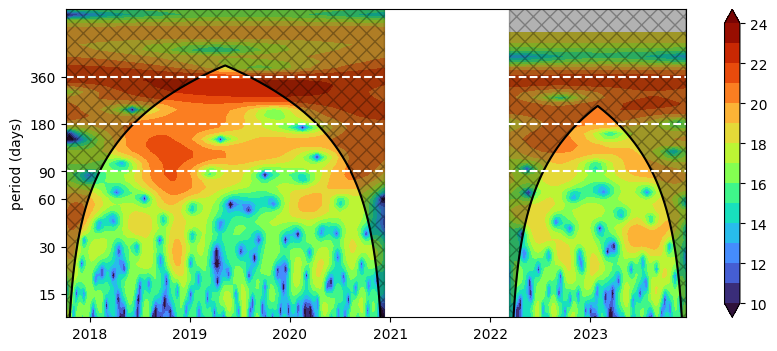

In [94]:
plt.figure(figsize=(10,4))
plt.contourf(ds40.TIME1[0:27907], np.log2(period1), np.log2(power1), extend='both',cmap="turbo",levels=np.arange(10,25,1))
#plt.contourf(wave1,cmap="turbo",levels=(np.arange(20,60,10)),extend="both")
plt.plot(ds40.TIME1[0:27907], np.log2(coi1),color='k')
plt.fill_between(ds40.TIME1[0:27907],np.log2(coi1),16,color='k',alpha=0.3,hatch='xx')

plt.contourf(ds40.TIME1[38852:], np.log2(period2), np.log2(power2), extend='both',cmap="turbo",levels=np.arange(10,25,1))
plt.plot(ds40.TIME1[38852:], np.log2(coi2),color='k')
plt.fill_between(ds40.TIME1[38852:],np.log2(coi2),16,color='k',alpha=0.3,hatch='xx')

plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')

plt.colorbar()
plt.ylim(8,14.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [95]:
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1[0:27907].values})
wavpow2=xr.DataArray(
    data=power2,
    dims=["period","time"],
    coords={"period":period2,'time':ds40.TIME1[38852:].values})

ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds40.TIME1[0:27907].values})
ci2=xr.DataArray(
    data=coi2,
    dims=["time"],
    coords={'time':ds40.TIME1[38852:].values}
)

sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1[0:27907].values})
sig2=xr.DataArray(
    data=sig952,
    dims=["period","time"],
    coords={"period":period2,'time':ds40.TIME1[38852:].values})
ds = xr.Dataset({
    'wavpow1': wavpow1,
    'wavpow2': wavpow2,
    'sig1': sig1,
    'sig2': sig2,
    'coi1': ci1,
    'coi2': ci2,
})
ds.to_netcdf(patho+str(files[4]))

# Kollam

In [37]:
ds = xr.open_dataset(path+files[5])
ds40 = ds.sel(DEPTH=40,method="nearest")
bm40d = np.array(ds40.BIOMASS[:,0,0].values)

bm40d_1 = detrend(bm40d)

wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm40d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

Text(0, 0.5, 'period (days)')

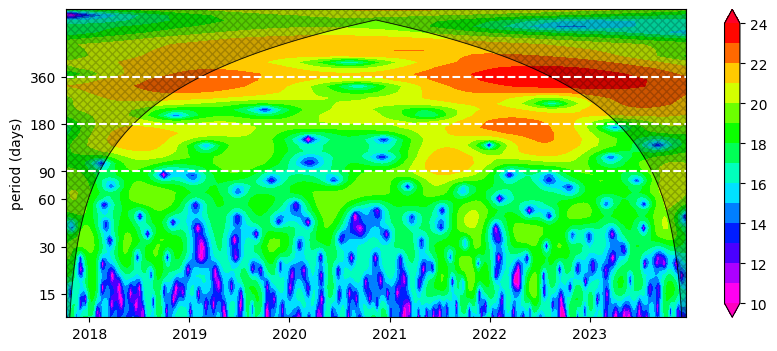

In [38]:
plt.figure(figsize=(10,4))

plt.contourf(ds40.TIME1, np.log2(period1), np.log2(power1), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,1))
plt.plot(ds40.TIME1, np.log2(coi1),color='k',linewidth=0.5)
plt.fill_between(ds40.TIME1,np.log2(coi1),16,color='k',alpha=0.2,hatch='xxxx')

plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')

plt.colorbar()
plt.ylim(8,14.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [39]:
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm40d_1)
alpha, _, _ = wavelet.ar1(bm40d_1)  # Lag-1 autocorrelation for red noise
std = bm40d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1.values})
ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds40.TIME1.values})
sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1.values})

ds = xr.Dataset({
    'wavpow1': wavpow1,
    'sig1': sig1,
    'coi1': ci1,
})

ds.to_netcdf(patho+str(files[5]))

# Kanyakumari

In [20]:
## special case: the gap between consecutive deployment was more than 3 days, not filled by graft filling, so made spline interpolation and filled


In [5]:
ds = xr.open_dataset(path+files[6])


In [6]:
ds401 = ds.sel(DEPTH=40,method="nearest")

In [8]:
ds40 = ds401.interpolate_na(dim="TIME1",method="spline")

In [9]:
bm40d = np.array(ds40.BIOMASS[:,0,0].values)
bm40d_1 = detrend(bm40d)

wave1, scales1, freqs1, coi1, fft1, fftfreqs1 = cwt(bm40d_1,dt=1,dj=dj,s0=s0, J=-1, wavelet=mother)
power1 = (np.abs(wave1)) ** 2  # Wavelet power spectrum
period1 = 1 / freqs1  # Convert frequencies to periods

Text(0, 0.5, 'period (days)')

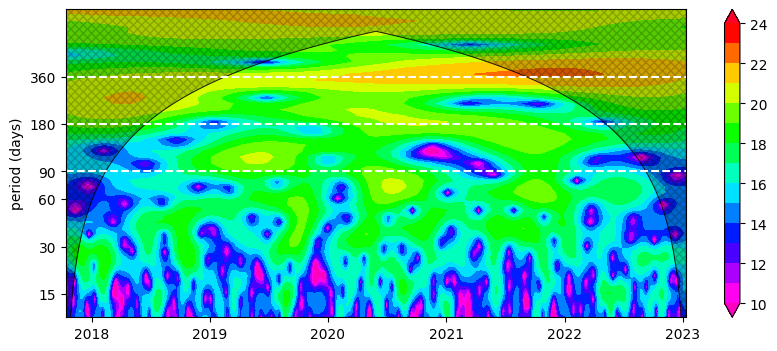

In [10]:
plt.figure(figsize=(10,4))

plt.contourf(ds40.TIME1, np.log2(period1), np.log2(power1), extend='both',cmap="gist_rainbow_r",levels=np.arange(10,25,1))
plt.plot(ds40.TIME1, np.log2(coi1),color='k',linewidth=0.5)
plt.fill_between(ds40.TIME1,np.log2(coi1),16,color='k',alpha=0.2,hatch='xxxx')

plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')
plt.axhline(np.log2(24*360),color='w',linestyle='--')

plt.colorbar()
plt.ylim(8,14.5)

customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

In [11]:
period1 = 1 / freqs1  # Convert frequencies to periods
N = len(bm40d_1)
alpha, _, _ = wavelet.ar1(bm40d_1)  # Lag-1 autocorrelation for red noise
std = bm40d_1.std()  # Standard deviation
var = std ** 2  # Variance
signif, fft_theor = wavelet.significance(bm40d_1, dt, scales1, 0, alpha,
                                         significance_level=0.95,
                                         wavelet=mother)
sig951 = np.ones([1, N]) * signif[:, None]
sig951 = power1 / sig951
wavpow1 = xr.DataArray(
    data=power1,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1.values})
ci1 = xr.DataArray(
    data=coi1,
    dims=["time"],
    coords={'time':ds40.TIME1.values})
sig1 = xr.DataArray(
    data=sig951,
    dims=["period","time"],
    coords={"period":period1,'time':ds40.TIME1.values})

ds = xr.Dataset({
    'wavpow1': wavpow1,
    'sig1': sig1,
    'coi1': ci1,
})

ds.to_netcdf(patho+str(files[6]))

# OKHA data recreated

In [29]:
ds = xr.open_dataset(patho+"1okha_graftfill.nc")

In [30]:
ds

<xarray.Dataset> Size: 97MB
Dimensions:  (period: 82, time: 36537)
Coordinates:
  * period   (period) float64 656B 24.79 27.04 29.48 ... 2.539e+04 2.769e+04
  * time     (time) datetime64[ns] 292kB 2018-10-06T16:00:00 ... 2023-12-11T0...
Data variables:
    wavpow1  (period, time) float64 24MB ...
    wavpow2  (period, time) float64 24MB ...
    sig1     (period, time) float64 24MB ...
    sig2     (period, time) float64 24MB ...
    coi1     (time) float64 292kB ...
    coi2     (time) float64 292kB ...

Text(0, 0.5, 'period (days)')

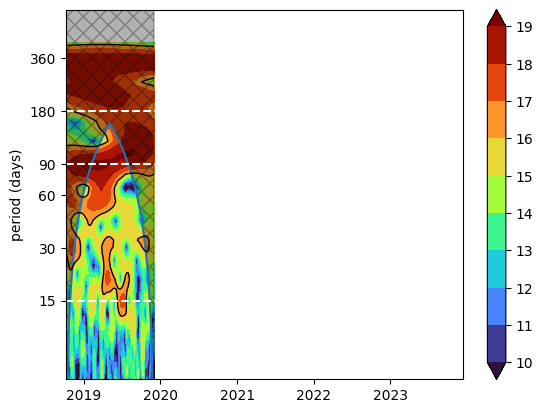

In [49]:
x = plt.contourf(ds.time,np.log2(ds.period),np.log2(ds.wavpow1),extend='both',cmap="turbo",levels=np.arange(10,20,1))
plt.plot(ds.time, np.log2(ds.coi1))
plt.fill_between(ds.time, np.log2(ds.coi1),16,color='k',alpha=0.3,hatch='xx')

extent = [ds.time.min(), ds.time.max(), 0, max(ds.period)]
plt.contour(ds.time, np.log2(ds.period), ds.sig1,levels=[-99,1], colors='k', linewidths=1,extent=extent)
plt.ylim(7,13)

plt.axhline(np.log2(24),color='w',linestyle='--')
plt.axhline(np.log2(24*15),color='w',linestyle='--')
plt.axhline(np.log2(24*90),color='w',linestyle='--')
plt.axhline(np.log2(24*180),color='w',linestyle='--')


plt.colorbar(x)

plt.ylim(7,14)
customticks = [15*24,30*24,60*24,90*24,180*24,360*24]
customticks = [np.log2(e) for e in customticks]
customlabel = ["15","30","60","90","180","360"]
plt.yticks(customticks)
plt.gca().set_yticklabels(customlabel)
plt.ylabel("period (days)")

0.7758
0.7902
0.6377
0.5381
0.5212
0.7438
0.7085
